# Food Hazard and Product Classification
## Using Separate Models for Hazard and Product Categories

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## Data Loading and Preprocessing

In [11]:
# Load the labelled incidents data
df = pd.read_csv('datas/incidents_labelled.csv')
print(f"Dataset shape: {df.shape}")
data_randomized = df.sample(frac=1, random_state=1)
df.head()

Dataset shape: (5984, 11)


,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [12]:
import re
df['title'] = df['title'].str.lower().str.replace('[^a-z\s]', '', regex=True)

def remove_pra_no(text):
    pattern = r'PRA No\. \d+/\d+'
    return re.sub(pattern, '', text)

df['text'] = df['text'].apply(remove_pra_no)
df['text'][72]
df['text'][5979]

'Imported biscuit may contain allergen (peanuts) The Centre for Food Safety (CFS) of the Food and Environmental Hygiene Department today (July 28) said that a kind of imported biscuit may contain an allergen, peanuts, but it was not declared on the product\'s food label. Consumers who are allergic to peanuts are advised not to consume the affected batch of the product concerned. The trade should also stop using or selling the affected batch of the product immediately. Product details are as follows: Product name: Hazelnut Filled Biscuit Brand: CASINO Place of origin: France Packing size: 125 grams per pack Best before date: April 18, 2023 Importer: PARKnSHOP (HK) Limited A spokesman for the CFS said, "The CFS received a notification from the Rapid Alert System for Food and Feed (RASFF) of the European Commission that ingredient used in the production of the above-mentioned product may contain an allergen, peanuts, but it was not declared on the product\'s food label. According to the i

In [13]:
list = df['text'].tolist()
def remove_newlines(text):
    if isinstance(text, str):  
        return text.replace('\n', ' ')
    return text  
df['text'] = df['text'].apply(remove_newlines)

Data Cleaning

In [14]:
import re
import string

def clean_text(text):
    """
    Clean input raw text for NLP model training.
    Steps:
    - Lowercase conversion
    - Remove backslashes or escape chars
    - Remove excessive whitespace
    - Remove punctuation (optional, based on model needs)
    - Remove non-ASCII (if needed, else can be adjusted)
    """
    # Lowercase
    text = text.lower()
    # Remove backslashes and escape characters
    text = text.replace("\\", "")
    # Remove punctuation except essential ones if needed (here we remove all)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters
    text = text.encode('ascii', errors='ignore').decode()
    # Normalize white space
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['text'] = df['text'].apply(clean_text)


In [26]:
df['text'][2]

'case number 01494 date opened 03281994 date closed 07191994 recall class 1 press release yn y domestic est number 00819 m name willow foods inc imported product yn n foreign estab number na city falls city state ne country usa product ham sliced problem bacteria description listeria total pounds recalled 3950 pounds recovered 3809'

In [27]:
def extract_recall_case_info(text):
    """
    Extract structured information from the recall case text.
    Returns a dictionary with extracted fields or empty dict if info missing.
    """
    info = {}
    patterns = {
        'case_number': r'case number\s*(\S+)',
        'date_opened': r'date opened\s*(\S+)',
        'date_closed': r'date closed\s*(\S+)',
        'recall_class': r'recall class\s*(\S+)',
        'press_release': r'press release\s*yn\s*(\S+)',
        'domestic_est_number': r'domestic est number\s*(\S+)',
        'company_name': r'name\s*(.*?)(?=\s*imported product)',
        'imported_product': r'imported product\s*yn\s*(\S+)',
        'foreign_estab_number': r'foreign estab number\s*(.*?)(?=\s*city)',
        'city': r'city\s*(\S+)',
        'state': r'state\s*(\S+)',
        'country': r'country\s*(\S+)',
        'product': r'product\s*(.*?)(?=\s*problem)',
        'problem': r'problem\s*(\S+)',
        'description': r'description\s*(\S+)',
        'total_pounds_recalled': r'total pounds recalled\s*([\d,]+)',
        'pounds_recovered': r'pounds recovered\s*([\d,]+)'
    }
    
    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            info[key] = match.group(1).strip()
    return info

In [28]:
extract_recall_case_info(df['text'][2])

{'case_number': '01494',
 'date_opened': '03281994',
 'date_closed': '07191994',
 'recall_class': '1',
 'press_release': 'y',
 'domestic_est_number': '00819',
 'company_name': 'willow foods inc',
 'imported_product': 'n',
 'foreign_estab_number': 'na',
 'city': 'falls',
 'state': 'ne',
 'country': 'usa',
 'product': 'yn n foreign estab number na city falls city state ne country usa product ham sliced',
 'problem': 'bacteria',
 'description': 'listeria',
 'total_pounds_recalled': '3950',
 'pounds_recovered': '3809'}

In [17]:
def extract_product_recall_info(text):
    """
    Extract structured in formation from the product recall alert text.
    Returns a dictionary with extracted fields or empty dict if info missing.
    """
    info = {}
    patterns = {
        'product_name': r'product name:\s*(.*?)(?=\s*pack size:)',
        'pack_size': r'pack size:\s*(.*?)(?=\s*use by date:)',
        'use_by_date': r'use by date:\s*(.*?)(?=\s*allergen:)',
        'allergen': r'allergen:\s*(.*?)(?=\s*do not eat)',
        'description': r'description:\s*(.*?)(?=\s*if you have bought)',
        'contact_info': r'contact the (.*?)(?=\s*for a full refund)',
        'refund_info': r'return it to your nearest (.*?)(?=\s*for a full refund)'
    }
    
    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            info[key] = match.group(1).strip()
    return info

In [18]:
def process_batch(text_list):
    """
    Process batch of raw text inputs.
    Returns a list of dictionaries with cleaned text and extracted product info.
    """
    processed = []
    for raw_text in text_list:
        cleaned = clean_text(raw_text)
        if "case number" in cleaned:
            recall_info = extract_recall_case_info(cleaned)
        else:
            recall_info = extract_product_recall_info(cleaned)
        processed.append({'cleaned_text': cleaned, 'recall_info': recall_info})
    return processed

In [19]:
# Extract texts and labels
texts = df['text'].values
hazard_labels = df['hazard-category'].values
product_labels = df['product-category'].values

# Encode labels
hazard_encoder = LabelEncoder()
product_encoder = LabelEncoder()

hazard_labels_encoded = hazard_encoder.fit_transform(hazard_labels)
product_labels_encoded = product_encoder.fit_transform(product_labels)

print(f"Number of hazard categories: {len(hazard_encoder.classes_)}")
print(f"Number of product categories: {len(product_encoder.classes_)}")
print(hazard_labels)
print(hazard_labels_encoded)

Number of hazard categories: 10
Number of product categories: 22
['biological' 'biological' 'biological' ... 'biological' 'allergens'
 'biological']
[1 1 1 ... 1 0 1]


## Dataset and Model Classes

In [8]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Model Training

In [9]:
# Split data
train_texts, val_texts, train_hazard_labels, val_hazard_labels, train_product_labels, val_product_labels = train_test_split(
    texts, hazard_labels_encoded, product_labels_encoded,
    test_size=0.2, random_state=42
)

In [10]:
# Initialize tokenizer and models
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

hazard_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(hazard_encoder.classes_)
).to(device)

product_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(product_encoder.classes_)
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def train_model(model, train_loader, val_loader, epochs=3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print("Classification Report:")
        print(classification_report(all_labels, all_preds))
        
    return train_losses, val_losses

In [12]:
# Create datasets and dataloaders for hazard classification
train_hazard_dataset = TextDataset(train_texts, train_hazard_labels, tokenizer)
val_hazard_dataset = TextDataset(val_texts, val_hazard_labels, tokenizer)

train_hazard_loader = DataLoader(train_hazard_dataset, batch_size=8, shuffle=True)
val_hazard_loader = DataLoader(val_hazard_dataset, batch_size=8)

# Train hazard model
print("Training hazard classification model...")
hazard_train_losses, hazard_val_losses = train_model(hazard_model, train_hazard_loader, val_hazard_loader)

Training hazard classification model...
Epoch 1/3
Training Loss: 0.7052
Validation Loss: 0.3898
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       377
           1       0.97      0.97      0.97       398
           2       0.77      0.97      0.86       107
           3       0.00      0.00      0.00         7
           4       0.93      0.96      0.94       166
           5       0.57      0.42      0.48        77
           6       0.00      0.00      0.00         1
           7       0.50      0.23      0.32        13
           8       0.60      0.18      0.28        33
           9       0.75      0.33      0.46        18

    accuracy                           0.89      1197
   macro avg       0.60      0.51      0.53      1197
weighted avg       0.88      0.89      0.88      1197

Epoch 2/3
Training Loss: 0.3123
Validation Loss: 0.4063
Classification Report:
              precision    recall  f1-score

In [13]:
# Create datasets and dataloaders for product classification
train_product_dataset = TextDataset(train_texts, train_product_labels, tokenizer)
val_product_dataset = TextDataset(val_texts, val_product_labels, tokenizer)

train_product_loader = DataLoader(train_product_dataset, batch_size=8, shuffle=True)
val_product_loader = DataLoader(val_product_dataset, batch_size=8)

# Train product model
print("Training product classification model...")
product_train_losses, product_val_losses = train_model(product_model, train_product_loader, val_product_loader)

Training product classification model...
Epoch 1/3
Training Loss: 1.9528
Validation Loss: 1.3307
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.67      0.66      0.66       149
           2       0.45      0.70      0.55        44
           3       1.00      0.08      0.15        38
           4       0.75      0.19      0.31        31
           5       0.67      0.50      0.57         4
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.44      0.84      0.58       127
          10       0.50      0.03      0.06        34
          11       0.00      0.00      0.00         2
          12       0.97      0.65      0.78        52
          13       0.83      0.88      0.86       351
          14       0.45      0.69      0.55        29
          15   

## Making Predictions

In [14]:
# Load submission data
submission_df = pd.read_csv('submission.csv')
submission_texts = submission_df['text'].values

# Create submission dataset
submission_dataset = TextDataset(submission_texts, [0]*len(submission_texts), tokenizer)
submission_loader = DataLoader(submission_dataset, batch_size=8)

In [15]:
def make_predictions(model, dataloader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

In [16]:
# Make predictions
hazard_predictions = make_predictions(hazard_model, submission_loader)
product_predictions = make_predictions(product_model, submission_loader)

# Decode predictions
hazard_categories = hazard_encoder.inverse_transform(hazard_predictions)
product_categories = product_encoder.inverse_transform(product_predictions)

# Create submission dataframe
submission_df['hazard-category'] = hazard_categories
submission_df['product-category'] = product_categories

# Save predictions
submission_df.to_csv('separated_predictions.csv', index=False)
print("Predictions saved to separated_predictions.csv")

Predictions saved to separated_predictions.csv


## Model Evaluation

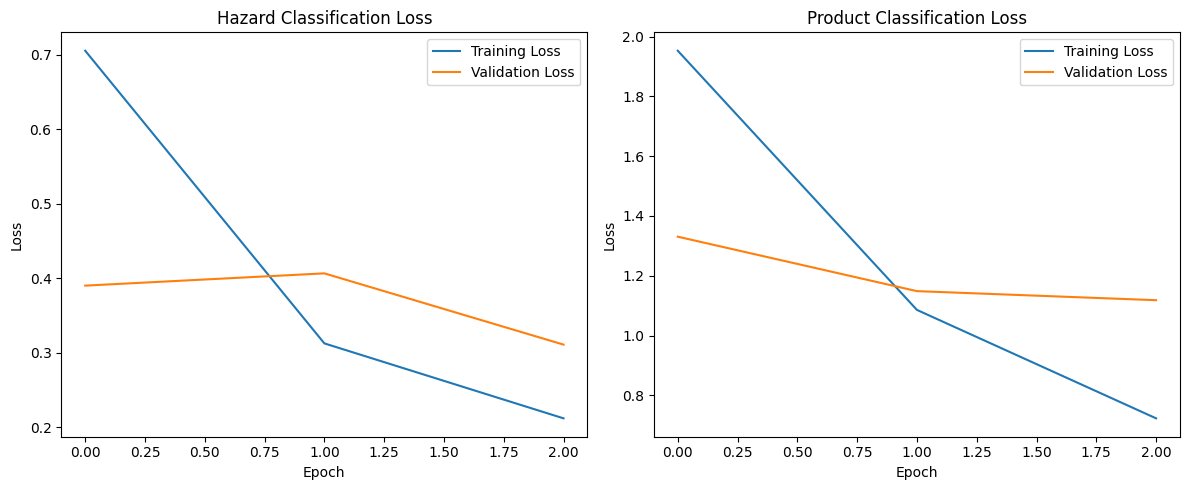

In [17]:
# Plot training and validation losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hazard_train_losses, label='Training Loss')
plt.plot(hazard_val_losses, label='Validation Loss')
plt.title('Hazard Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(product_train_losses, label='Training Loss')
plt.plot(product_val_losses, label='Validation Loss')
plt.title('Product Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()